This notebook is designed to run in a Python environment having DAGMA package.

It is recommended to create a dedicated Conda environment for this notebook using the following command: conda create --name dagma python=3.x dagma

In [1]:
# !pip install dagma

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
from input_data import load_sz_data

import matplotlib.pyplot as plt
import time
from dagma import utils
from dagma.linear import DagmaLinear
# from dagma.nonlinear import DagmaMLP, DagmaNonlinear
import networkx as nx

d:\ProgramData\Anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
time_start = time.time()
###### Settings ######
data_name = 'sz'

data, adj = load_sz_data('sz')
# Drop the first 11 days
data = data.drop(data.index[:1056])

time_len = data.shape[0]
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32)

#### normalization
max_value = np.max(data1)
data1 = data1/max_value

In [4]:
type(adj[0,0]), adj.shape, type(adj)

(numpy.int64, (156, 156), numpy.matrix)

In [5]:
G = nx.from_numpy_matrix(adj, create_using=nx.DiGraph)

# Check if the graph is a DAG
is_dag = nx.is_directed_acyclic_graph(G)

print("The graph is a DAG:", is_dag)

The graph is a DAG: False


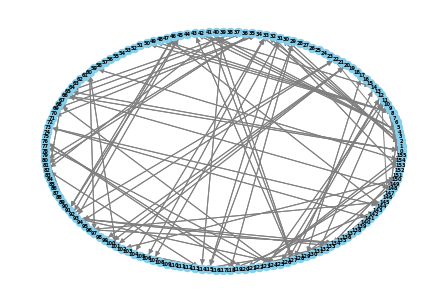

In [6]:
# Draw the graph
# pos = nx.spring_layout(G)  # positions for all nodes
pos = nx.circular_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=70, node_color='skyblue', font_size=5, font_color='black', font_weight='bold', edge_color='gray')
plt.show()


In [7]:
print(time_len, num_nodes)
print(data.shape, data1.shape)

1920 156
(1920, 156) (1920, 156)


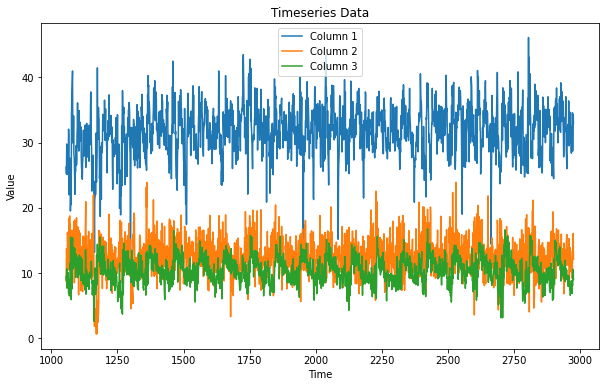

In [8]:
plt.figure(figsize=(10, 6))  # Set the figure size

for i in range(3):  
    plt.plot(data.iloc[:, i], label=f'Column {i+1}')  # Plot the column data with a label

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.title('Timeseries Data')  # Set the title of the plot
plt.legend()  # Show the legend

plt.show()  # Show the plot


In [9]:
%%time
W_true = adj

pred_list = [1]#[1,2,3,4]
num_nodes = data.shape[1]
for pre_len in pred_list:
    W_est_all = np.zeros((num_nodes,num_nodes,pre_len))
    for i in range(pre_len):
        X = data.values
        # Considering prediction length
        X = X[i::pre_len]
        model = DagmaLinear(loss_type='l2') # create a linear model with least squares loss
        w_est = model.fit(X, lambda1=0.02) # fit the model with L1 reg. (coeff. 0.02)
        W_est_all[:,:,i] = w_est

        acc = utils.count_accuracy(W_true, w_est > 0) # compute metrics of estimated adjacency matrix W_est with ground-truth
        print(pre_len, w_est.shape, acc, np.count_nonzero(w_est > 0))

    W_est_file_name = f"est_adj/W_est_{data_name}_pre_len{pre_len}.npy"
    # np.save(W_est_file_name, W_est_all)

100%|██████████| 180000/180000.0 [04:19<00:00, 693.65it/s] 

1 (156, 156) {'fdr': 0.18055555555555555, 'tpr': 1.218045112781955, 'fpr': 0.002249524139124416, 'shd': 174, 'nnz': 144} 144
Wall time: 4min 19s


In [10]:
adj_all = np.zeros(W_est_all.shape, dtype=int)
# Update values in adj based on the condition
adj_all[W_est_all > 0] = 1
adj = np.any(adj_all, axis=2)
W_est = adj.astype(int)
print('adj.shape=', adj.shape, type(adj[0,0]))
W_est_file_name = f"est_adj/W_est_{data_name}_pre_len{pre_len}.npy"
np.save(W_est_file_name, W_est_all)

adj.shape= (156, 156) <class 'numpy.bool_'>


The saved W_est will be loaded in main.py

In [11]:
pre_len = 1
W_est_file_name = f"est_adj/W_est_{data_name}_pre_len{pre_len}.npy"
W_est_all = np.load(W_est_file_name)
W_est_all.shape

(156, 156, 1)

In [12]:
adj_matrix = W_est_all[:,:,0]
dag = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph)

# Check if the graph is a DAG
is_dag = nx.is_directed_acyclic_graph(dag)

print("The graph is a DAG:", is_dag)

The graph is a DAG: True


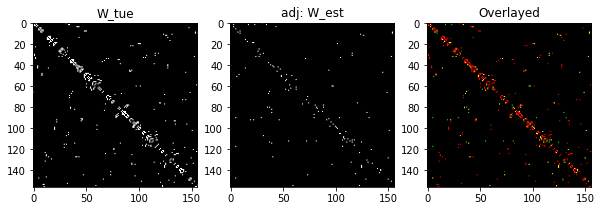

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(W_true.astype(np.uint8), cmap='gray')
axs[0].set_title('W_tue')

axs[1].imshow(W_est, cmap='gray')
axs[1].set_title('adj: W_est')

overlay_image = np.zeros((W_true.shape[0], W_true.shape[1], 3), dtype=np.uint8)
overlay_image[..., 0] = W_true * 255  # Red channel
overlay_image[..., 1] = W_est * 255   # Green channel

axs[2].imshow(overlay_image)
axs[2].set_title('Overlayed')

plt.show()